<a href="https://colab.research.google.com/github/ssandanshi/Super-Resolution-GAN/blob/master/Neural_Network_F2_SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import pickle

# Data Generator

In [0]:
import os
import tensorflow as tf

from tensorflow.python.data.experimental import AUTOTUNE

In [0]:
class DIV2K:
    def __init__(self,
                 scale=2,
                 subset='train',
                 downgrade='bicubic',
                 images_dir='.div2k/images',
                 caches_dir='.div2k/caches'):

        self._ntire_2018 = True

        _scales = [2, 3, 4, 8]

        if scale in _scales:
            self.scale = scale
        else:
            raise ValueError(f'scale must be in ${_scales}')

        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        _downgrades_a = ['bicubic', 'unknown']
        _downgrades_b = ['mild', 'difficult']

        if scale == 8 and downgrade != 'bicubic':
            raise ValueError(f'scale 8 only allowed for bicubic downgrade')

        if downgrade in _downgrades_b and scale != 4:
            raise ValueError(f'{downgrade} downgrade requires scale 4')

        if downgrade == 'bicubic' and scale == 8:
            self.downgrade = 'x8'
        elif downgrade in _downgrades_b:
            self.downgrade = downgrade
        else:
            self.downgrade = downgrade
            self._ntire_2018 = False

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        if not os.path.exists(self._hr_images_dir()):
            download_archive(self._hr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._hr_image_files()).cache(self._hr_cache_file())

        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        return ds

    def lr_dataset(self):
        if not os.path.exists(self._lr_images_dir()):
            download_archive(self._lr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._lr_image_files()).cache(self._lr_cache_file())

        if not os.path.exists(self._lr_cache_index()):
            self._populate_cache(ds, self._lr_cache_file())

        return ds

    def _hr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_HR.cache')

    def _lr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def _hr_cache_index(self):
        return f'{self._hr_cache_file()}.index'

    def _lr_cache_index(self):
        return f'{self._lr_cache_file()}.index'

    def _hr_image_files(self):
        images_dir = self._hr_images_dir()
        return [os.path.join(images_dir, f'{image_id:04}.png') for image_id in self.image_ids]

    def _lr_image_files(self):
        images_dir = self._lr_images_dir()
        return [os.path.join(images_dir, self._lr_image_file(image_id)) for image_id in self.image_ids]

    def _lr_image_file(self, image_id):
        if not self._ntire_2018 or self.scale == 8:
            return f'{image_id:04}x{self.scale}.png'
        else:
            return f'{image_id:04}x{self.scale}{self.downgrade[0]}.png'

    def _hr_images_dir(self):
        return os.path.join(self.images_dir, f'DIV2K_{self.subset}_HR')

    def _lr_images_dir(self):
        if self._ntire_2018:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}')
        else:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}', f'X{self.scale}')

    def _hr_images_archive(self):
        return f'DIV2K_{self.subset}_HR.zip'

    def _lr_images_archive(self):
        if self._ntire_2018:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}.zip'
        else:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.zip'

    @staticmethod
    def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


# -----------------------------------------------------------
#  Transformations
# -----------------------------------------------------------


def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)


# -----------------------------------------------------------
#  IO
# -----------------------------------------------------------


def download_archive(file, target_dir, extract=True):
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))

In [0]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='unknown')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='unknown')

In [7]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

208961536/208956781 [==============================] - 8s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_unknown_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_unknown_X4.cache.
3530604544/3530603713 [==============================] - 124s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
26697728/26695095 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_unknown_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_unknown_X4.cache.
448995328/448993893 [==============================] - 17s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


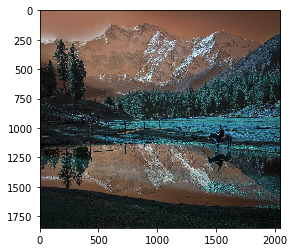

In [0]:
plt.imshow(cv2.imread('.div2k/images/DIV2K_train_HR/0002.png'))

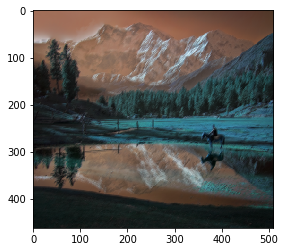

In [0]:
plt.imshow(cv2.imread('.div2k/images/DIV2K_train_LR_unknown/X4/0002x4.png'))

# Evaluation (PSNR)

In [0]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

In [0]:
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)


# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5


# ---------------------------------------
#  Metrics
# ---------------------------------------


def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)


# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


In [0]:
def evaluate_psnr(groundtruth,pred):
  #return -10. * np.log10(np.mean(np.square(pred - groundtruth)))
  #return tf.image.psnr(groundtruth, pred, max_val=255)
  max_pixel = 1.0
  return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(pred - groundtruth), axis=-1)))) / 2.303

# Model

In [0]:
import time
import tensorflow as tf

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

In [0]:
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19

In [0]:
#source: https://github.com/twairball/keras-subpixel-conv
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)


    return Lambda(subpixel, output_shape=subpixel_shape)

In [0]:
def residual_block(x_in, num_filters,kernel_size):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_in, x])
    return x

In [0]:
def generator(input_shape=(None,None,3),num_filters=64, num_res_blocks=16, kernel_size=3):
    x = x_in = Input(shape=input_shape)
    x = Lambda(normalize_01)(x_in)

    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = x_1 = Activation('relu')(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters,kernel_size=kernel_size)

    x = Conv2D(num_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    #upsample
    x = Conv2D(256, 3, padding='same')(x)
    x = SubpixelConv2D(input_shape=x.shape,scale=2)(x)
    x = Activation('relu')(x)

    x = Conv2D(256, 3, padding='same')(x)
    x = SubpixelConv2D(input_shape=x.shape,scale=2)(x)
    x = Activation('relu')(x)

    x = Conv2D(3, kernel_size=1, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_m11)(x)
    return Model(x_in, x, name='generator')


In [0]:
def discriminator_block(x,num_filters=64,kernel_size=3,strides=1,activation='relu',batchnorm=True):
  x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  if batchnorm:
      x = BatchNormalization()(x)
  if activation == "lrelu":
    x = LeakyReLU(alpha=0.2)(x)
  elif activation == 'relu':
    x = Activation('relu')(x)
  return x

In [0]:
def discriminator(input_shape=(96,96,3),num_filters=64):
  x = x_in = Input(shape=input_shape)
  x = Lambda(normalize_m11)(x_in)

  x = discriminator_block(x,num_filters=num_filters,kernel_size=4,strides=2,activation='lrelu',batchnorm=False)
  x = discriminator_block(x,num_filters=num_filters*2,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*4,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*8,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*16,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*32,kernel_size=4,strides=2,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*16,kernel_size=1,strides=1,activation='lrelu',batchnorm=True)
  x_1 = x = discriminator_block(x,num_filters=num_filters*8,kernel_size=1,strides=1,activation=None,batchnorm=True)

  x = discriminator_block(x,num_filters=num_filters*2,kernel_size=1,strides=1,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*2,kernel_size=3,strides=1,activation='lrelu',batchnorm=True)
  x = discriminator_block(x,num_filters=num_filters*8,kernel_size=3,strides=1,activation=None,batchnorm=True)

  x = Add()([x_1, x])
  x = LeakyReLU(alpha=0.2)(x)
  x = Flatten()(x)

  #Hidden FNN Layer
  x = Dense(1024)(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Dense(1, activation='sigmoid')(x)

  return Model(x_in, x, name='discriminator')


In [0]:
def vgg_22():
    return _vgg(5)


def vgg_54():
    return _vgg(20)


def _vgg(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

In [79]:
gan_generator = generator()
gan_generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, None, None, 6 1792        lambda_8[0][0]                   
__________________________________________________________________________________________________
activation_79 (Activation)      (None, None, None, 6 0           conv2d_187[0][0]                 
__________________________________________________________________________________________

In [80]:
gan_discriminator = discriminator()
gan_discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 96, 96, 3)    0           input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 48, 48, 64)   3136        lambda_12[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_32 (LeakyReLU)      (None, 48, 48, 64)   0           conv2d_224[0][0]                 
______________________________________________________________________________________

# Pre Training Generator

In [0]:
class Trainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/gan_pre'):

        self.now = None
        self.loss = loss
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              optimizer=Adam(learning_rate),
                                              model=model)
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_dir,
                                                             max_to_keep=3)

        self.restore()

    @property
    def model(self):
        return self.checkpoint.model

    def train(self, train_dataset, valid_dataset, steps, evaluate_every=1000, save_best_only=False):
        loss_mean = Mean()

        ckpt_mgr = self.checkpoint_manager
        ckpt = self.checkpoint

        self.now = time.perf_counter()

        for lr, hr in train_dataset.take(steps - ckpt.step.numpy()):
            ckpt.step.assign_add(1)
            step = ckpt.step.numpy()

            loss = self.train_step(lr, hr)
            loss_mean(loss)

            if step % evaluate_every == 0:
                loss_value = loss_mean.result()
                loss_mean.reset_states()

                # Compute PSNR on validation dataset
                psnr_value = self.evaluate(valid_dataset)

                duration = time.perf_counter() - self.now
                print(f'{step}/{steps}: loss = {loss_value.numpy():.3f}, PSNR = {psnr_value.numpy():3f} ({duration:.2f}s)')

                if save_best_only and psnr_value <= ckpt.psnr:
                    self.now = time.perf_counter()
                    # skip saving checkpoint, no PSNR improvement
                    continue

                ckpt.psnr = psnr_value
                ckpt_mgr.save()

                self.now = time.perf_counter()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.checkpoint.model(lr, training=True)
            loss_value = self.loss(hr, sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return loss_value

    def evaluate(self, dataset):
        return evaluate(self.checkpoint.model, dataset)

    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')

In [0]:
learning_rate=0.0001
checkpoint_dir='./ckpt/gan_pre'
loss=MeanSquaredError()
steps=1500
evaluate_every=steps%100
save_best_only=False

In [0]:
ganPreTrainer = Trainer(model=gan_generator,checkpoint_dir=checkpoint_dir,learning_rate=learning_rate,loss=loss)

In [88]:
ganPreTrainer.train(train_ds,valid_ds.take(10),steps,evaluate_every,save_best_only)
ganPreTrainer.model.save_weights('pre_generator.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in remainder


1/1500: loss = 6091.989, PSNR = 10.777369 (10.97s)
2/1500: loss = 5509.023, PSNR = 11.002543 (0.74s)
3/1500: loss = 5389.050, PSNR = 10.285051 (0.72s)
4/1500: loss = 4612.000, PSNR = 11.225257 (0.71s)
5/1500: loss = 4223.615, PSNR = 10.840703 (0.74s)
6/1500: loss = 5213.835, PSNR = 11.925169 (0.73s)
7/1500: loss = 4747.013, PSNR = 12.811506 (0.72s)
8/1500: loss = 5702.344, PSNR = 11.776015 (0.72s)
9/1500: loss = 3231.660, PSNR = 12.912231 (0.73s)
10/1500: loss = 2980.574, PSNR = 13.228412 (0.72s)
11/1500: loss = 3036.356, PSNR = 12.107851 (0.72s)
12/1500: loss = 3099.238, PSNR = 12.820391 (0.73s)
13/1500: loss = 2274.208, PSNR = 12.784330 (0.70s)
14/1500: loss = 2536.574, PSNR = 13.145173 (0.70s)
15/1500: loss = 2439.629, PSNR = 11.357668 (0.73s)
16/1500: loss = 2584.334, PSNR = 13.601059 (0.72s)
17/1500: loss = 1853.188, PSNR = 13.842287 (0.73s)
18/1500: loss = 1854.999, PSNR = 13.081329 (0.72s)
19/1500: loss = 1586.220, PSNR = 12.328187 (0.72s)
20/1500: loss = 2130.276, PSNR = 11.987

# Train Generator-Discriminator

In [0]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

In [0]:
class GANTrainer:
    def __init__(self,
                 generator,
                 discriminator,
                 content_loss='VGG54',
                 learning_rate=1e-4):

        if content_loss == 'VGG22':
            self.vgg = vgg_22()
        elif content_loss == 'VGG54':
            self.vgg = vgg_54()
        else:
            raise ValueError("content_loss must be either 'VGG22' or 'VGG54'")

        self.content_loss = content_loss
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = Adam(learning_rate=learning_rate)
        self.discriminator_optimizer = Adam(learning_rate=learning_rate)

        self.binary_cross_entropy = BinaryCrossentropy(from_logits=False)
        self.mean_squared_error = MeanSquaredError()

    def train(self, train_dataset, steps=200000):
        pls_metric = Mean()
        dls_metric = Mean()
        step = 0

        for lr, hr in train_dataset.take(steps):
            step += 1

            pl, dl = self.train_step(lr, hr)
            pls_metric(pl)
            dls_metric(dl)

            if step % 50 == 0:
                print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
                pls_metric.reset_states()
                dls_metric.reset_states()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.generator(lr, training=True)

            hr_output = self.discriminator(hr, training=True)
            sr_output = self.discriminator(sr, training=True)

            con_loss = self._content_loss(hr, sr)
            gen_loss = self._generator_loss(sr_output)
            perc_loss = con_loss + 0.001 * gen_loss
            disc_loss = self._discriminator_loss(hr_output, sr_output)

        gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return perc_loss, disc_loss

    @tf.function
    def _content_loss(self, hr, sr):
        sr = preprocess_input(sr)
        hr = preprocess_input(hr)
        sr_features = self.vgg(sr) / 12.75
        hr_features = self.vgg(hr) / 12.75
        return self.mean_squared_error(hr_features, sr_features)

    def _generator_loss(self, sr_out):
        return self.binary_cross_entropy(tf.ones_like(sr_out), sr_out)

    def _discriminator_loss(self, hr_out, sr_out):
        hr_loss = self.binary_cross_entropy(tf.ones_like(hr_out), hr_out)
        sr_loss = self.binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
        return hr_loss + sr_loss

In [91]:
gan_trainer = GANTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=2000)

80142336/80134624 [==============================] - 1s 0us/step
50/2000, perceptual loss = 0.1760, discriminator loss = 1.1329
100/2000, perceptual loss = 0.1724, discriminator loss = 0.8375
150/2000, perceptual loss = 0.1717, discriminator loss = 0.7800
200/2000, perceptual loss = 0.1675, discriminator loss = 0.6127
250/2000, perceptual loss = 0.1694, discriminator loss = 0.3708
300/2000, perceptual loss = 0.1641, discriminator loss = 1.0020
350/2000, perceptual loss = 0.1748, discriminator loss = 0.5228
400/2000, perceptual loss = 0.1694, discriminator loss = 0.5151
450/2000, perceptual loss = 0.1761, discriminator loss = 0.4372
500/2000, perceptual loss = 0.1743, discriminator loss = 0.3920
550/2000, perceptual loss = 0.1720, discriminator loss = 0.2944
600/2000, perceptual loss = 0.1717, discriminator loss = 0.4012
650/2000, perceptual loss = 0.1675, discriminator loss = 0.5946
700/2000, perceptual loss = 0.1717, discriminator loss = 0.3645
750/2000, perceptual loss = 0.1610, disc

In [0]:
gan_trainer.generator.save_weights('gan_generator.h5')
gan_trainer.discriminator.save_weights('gan_discriminator.h5')

# Predict

In [0]:
from PIL import Image

In [0]:
def load_image(path):
    return cv2.imread(path)

In [0]:
def plot_sample(lr, sr, hr,psnrLR=None,psnrSR=None):
    plt.figure(figsize=(20, 10))

    images = [lr, sr, hr]
    titles = ['LR', 'SR', 'HR']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        if title == 'LR':
          lrupscale = cv2.resize(img,(img.shape[1]*4,img.shape[0]*4))
          im = Image.fromarray(lrupscale)
          im.save(title+'-UP.png')
        im = Image.fromarray(img)
        im.save(title+'.png')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        if title == 'LR':
          plt.xlabel('PSNR: '+str(round(psnrLR.numpy(),2))+'dB')
        if title == 'SR':
          plt.xlabel('PSNR: '+str(round(psnrSR.numpy(),2))+'dB')

In [0]:
def resolve_and_plot(model,lr_image_path,hr_image_path):
    lr = load_image(lr_image_path)
    print(lr.shape)
    lr_tensor = tf.convert_to_tensor(np.array([lr]),dtype=tf.float32)
    lrupscale = cv2.resize(lr,(lr.shape[1]*4,lr.shape[0]*4))
    lrupscale_tensor = tf.convert_to_tensor(np.array([lrupscale]),dtype=tf.float32)
    print(lr_tensor.shape)
    sr_tensor = resolve(model,lr_tensor)[0]
    sr = sr_tensor.numpy()
    hr = load_image(hr_image_path)
    hr_tensor = tf.convert_to_tensor(np.array([hr]),dtype=tf.float32)
    psnrSR = psnr(hr_tensor, sr_tensor)[0]
    psnrLR = psnr(hr_tensor, lrupscale_tensor)[0]
    print(hr.shape)
    plot_sample(lr, sr, hr,psnrLR,psnrSR)

(339, 510, 3)
(1, 339, 510, 3)
(1356, 2040, 3)


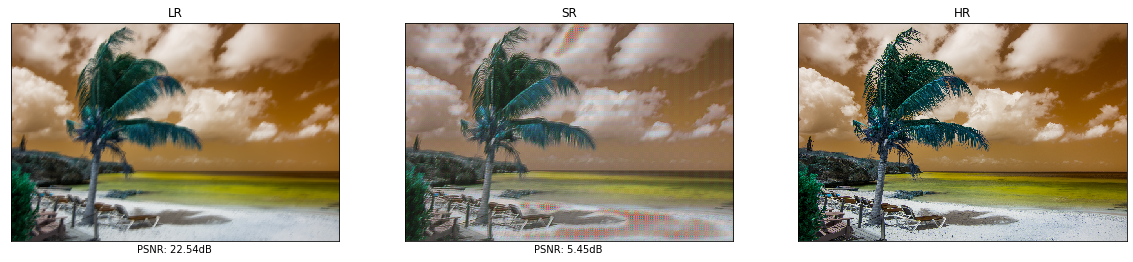

In [102]:
resolve_and_plot(gan_generator,'.div2k/images/DIV2K_valid_LR_unknown/X4/0806x4.png','.div2k/images/DIV2K_valid_HR/0806.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

(411, 510, 3)
(1, 411, 510, 3)
(1644, 2040, 3)


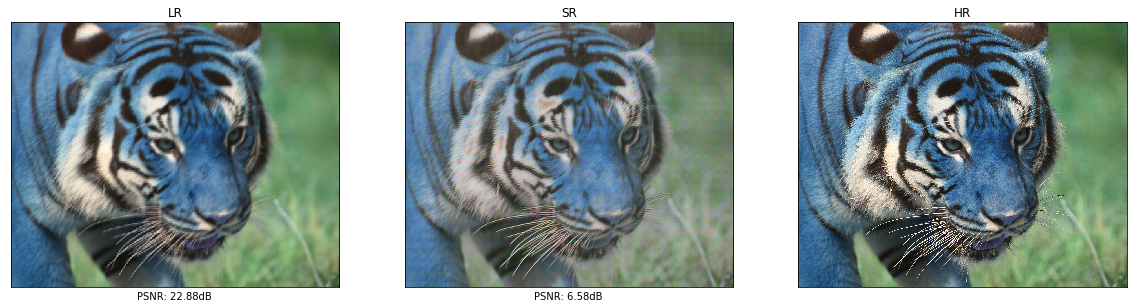

In [100]:
resolve_and_plot(gan_generator,'.div2k/images/DIV2K_train_LR_unknown/X4/0010x4.png','.div2k/images/DIV2K_train_HR/0010.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

# Pre Output

In [0]:
pre_generator = generator()
pre_generator.load_weights('pre_generator.h5')

(411, 510, 3)
(1, 411, 510, 3)
(1644, 2040, 3)


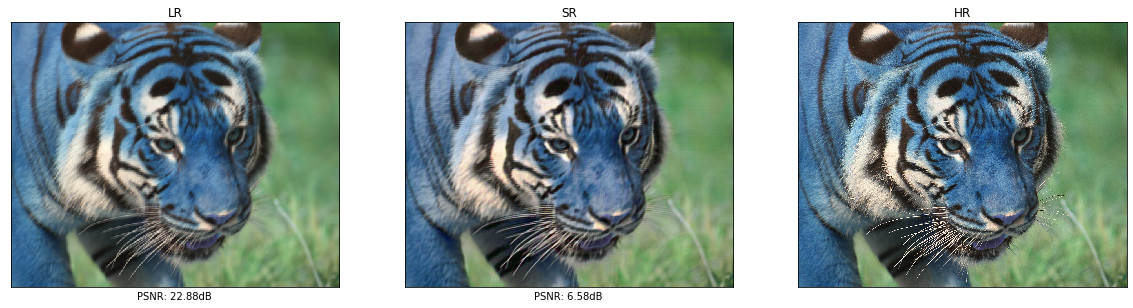

In [105]:
resolve_and_plot(pre_generator,'.div2k/images/DIV2K_train_LR_unknown/X4/0010x4.png','.div2k/images/DIV2K_train_HR/0010.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

(339, 510, 3)
(1, 339, 510, 3)
(1356, 2040, 3)


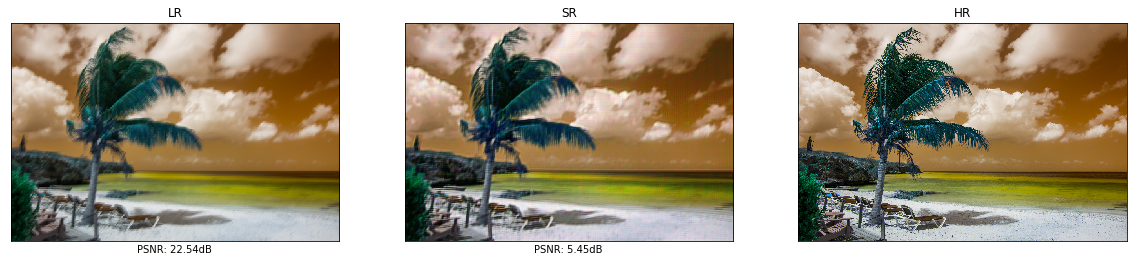

In [107]:
resolve_and_plot(pre_generator,'.div2k/images/DIV2K_valid_LR_unknown/X4/0806x4.png','.div2k/images/DIV2K_valid_HR/0806.png')

In [0]:
from google.colab import files
files.download('SR.png')
files.download('LR.png')
files.download('HR.png')
files.download('LR-UP.png')

In [0]:
!cp *.h5 gdrive/My\ Drive/SR/GAN